In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.text import *
from pathlib import Path
from fastai import *
from fastai.callbacks import *

In [2]:
path = Path('/home/jupyter/shopee/data')
bs = 64

# Language Model for Text 

## data_lm

In [3]:
df = pd.read_csv(path/'mobile_lm_train.csv')
df.shape

(200747, 1)

In [6]:
data_lm = (TextList.from_csv(path, 'mobile_lm_train.csv', cols='title')
                   .split_by_rand_pct()
                   .label_for_lm() 
                   .databunch(bs=bs))

In [7]:
data_lm.save('mobile_data_lm.pkl')

In [9]:
data_lm.show_batch()

idx,text
0,j1 mini sm j105 8 gb white xxbos iphone 5 white 16 gb fullset mulus xxbos lenovo a 6000 se 1 16 white xxbos keypad blackberry 9360 hitam xxbos xiaomi redmi 3pro 3s xxbos iphone 5 garansi 1 thn platinum xxbos iphone 5s 32 gb xxbos hdc samsung galaxy s7 8 gb quadcore xxbos original uag urban armor gear trooper series iphone 7 plus 6s 6 black xxbos iphone
1,spesial big promo handpone aksesoris android samsung galaxy j7 prim 8 gb xxbos kamera belakang big back camera xiaomi mi max xxbos asus zenfone zoom s xxbos samsung j7 prime xxbos samsung j1 ace new 4 g xxbos iphone 6 plus hdc ultra gold 64 gb xxbos maxtron mg c28 dual sim 1.8 xxbos samsung j5 pro black seken 95 mulus xxbos samsung galaxy j5 xxbos original uag urban
2,bergaransi xxbos wa 082192415957 google pixel 2 xl xxbos dijual cepat iphone 6 32 gb xxbos samsung galaxy c9 pro gold ram 6 gb rom 64 gb xxbos wa:087740782277 khusus promo hari ini beli 2 gratis 1 vivo v7 64 gb new asli orginal xxbos vivo v9 xxbos whatsapp 089503643643 promo dahsyat beli 1 gratis samsung galaxy tab s2 t819 tablet 2016 xxbos beli 2 gratis 1 ready samsung
3,chat xxbos nokia x2 01 gsm original garansi 1 bulan xxbos xiaomi redmi 5plus ram 4 gb rom 64 gb garansi tam xxbos big promo hari jadi toko kami samsung xxbos habisin stock original spigen air skin samsung galaxy s8 plus black termurah promo ramadhan xxbos spesial rhamadan iphone 7 red 128 gb full set big sale beli 2 gratis 1 chat wa+6283135960444 apple xxbos apple iphone 8 stock
4,promo lfg asus zenfone 5 ze620kl 4 gb 64 gb garansi ready stok xxbos hot promo nokia 105 lcd xxbos wa o83i 3612 2567 second xiaomi note 4 snapdragon 64 4 gb 64 gb masih garansi 3 bulan xxbos oppo a83 smart selfie full screen xxbos oppo find x xxbos nokia 6 android wa o878 439o 2777 xxbos murah apple watch series 3 38 mm gps space gray aluminum


## load old data_lm

In [8]:
data_lm = load_data(path, 'mobile_data_lm.pkl', bs=bs)

## train language model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


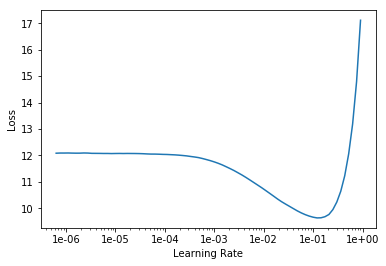

In [10]:
learn = language_model_learner(data_lm, Transformer)
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.876686,3.679631,0.320528,02:25


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


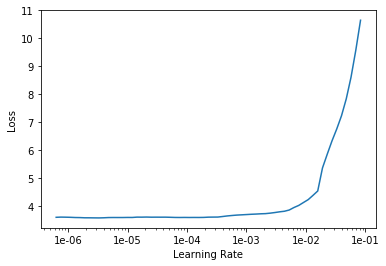

In [23]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,3.685382,3.575245,0.330398,02:24
1,3.493437,3.373336,0.348209,02:24
2,3.321667,3.204412,0.363298,02:24
3,3.198334,3.093510,0.376558,02:25
4,3.116613,3.024260,0.382165,02:25
5,3.044116,2.966533,0.389431,02:25
6,2.987674,2.907479,0.396273,02:25
7,2.936462,2.876107,0.400267,02:25
8,2.889587,2.843718,0.403719,02:25
9,2.850892,2.818888,0.406689,02:25


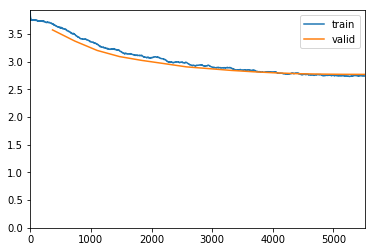

/opt/anaconda3/lib/python3.7/site-packages/fastai/callbacks/tracker.py:48: UserWarning: <class 'fastai.callbacks.tracker.SaveModelCallback'> conditioned on metric `error_rate` which is not available. Available metrics are: train_loss, valid_loss, accuracy, time
  warn(f'{self.__class__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:]))}')


In [14]:
learn.fit_one_cycle(15, 3e-3, moms=(0.8,0.7), callbacks=[ShowGraph(learn),SaveModelCallback(learn,monitor='error_rate',mode='min')])

In [16]:
learn.save('mobile_fine_tuned_transformer')
learn.save_encoder('mobile_fine_tuned_transformer_enc')

In [17]:
TEXT = "iphone"
N_WORDS = 10
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

iphone 6 galaxy s8 gb gold dual sim xxbos iphone 6s
iphone 6s 64 gb xxbos promo promo xxbos samsung galaxy j5


#  Text Classifier

## data_clas

In [18]:
df = pd.read_csv(path/'mobile_train_v3_sss.csv')
df.head()
df.isnull().values.any()

False

In [19]:
bs=128

In [21]:
data_clas = (TextList.from_df(df, cols='title', vocab = data_lm.vocab)
             .split_from_df(col='is_valid')
             .label_from_df(cols='Category')
             .databunch(bs=bs)
            )

In [25]:
data_clas.save(path/'mobile_data_clas.pkl')

In [23]:
data_clas.show_batch()

text,target
xxbos wa 62 831 3631 579 promo beli 2 gratis 1 oukitel k1 xxrep 4 0 max 1 xxrep 4 0 mah 3 gb 32 gb android 7 ip68,33
xxbos wa 085 xxrep 4 3 53797 harga promo beli 2 gratis 1 asus x441ua xxunk t i3 6006u 4 gb ddr3 hdd 500 gb win,43
xxbos wa 085 xxrep 4 3 53797 harga promo beli 2 gratis 1 samsung galaxy j5 pro 2017 16 gb j530 g ds 4 g,32
xxbos wa 085 xxrep 4 3 53797 promo ter murah beli 2 gratis 1 oppo f1s plus 4 gb 64 gb free powerbank dll,41
xxbos terlaris xiaomi powerbank 1 xxrep 4 0 mah power bank mi pro 2 1 xxrep 4 0 mah fast charging hitam,35


## load old data_clas

In [26]:
data_clas = load_data(path, 'mobile_data_clas.pkl', bs=bs)

## train text classifier

In [27]:
learn = text_classifier_learner(data_clas, Transformer,wd=1e-1, drop_mult=0.6)
learn.load_encoder('mobile_fine_tuned_transformer_enc')

In [28]:
learn.metrics=[accuracy,
               Precision(average='weighted'),
               Recall(average='weighted'),
               FBeta(average='weighted')]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


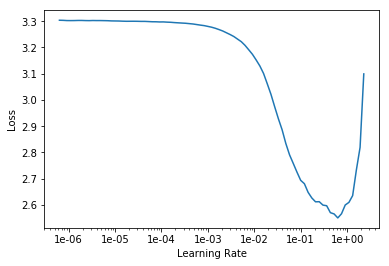

In [29]:
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(1, 3e-01, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,precision,recall,f_beta,time
0,0.809785,0.687125,0.834075,nan,0.834075,0.825958,02:29


In [34]:
learn.save('first')

In [32]:
learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


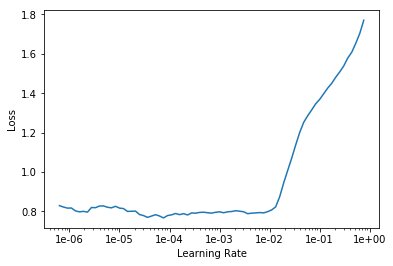

In [33]:
learn.lr_find()
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,precision,recall,f_beta,time
0,0.478084,0.458530,0.872891,0.871372,0.872891,0.867874,02:53


In [36]:
learn.save('second')

In [ ]:
learn.load('second')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


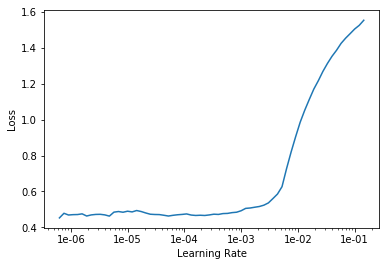

In [38]:
learn.freeze_to(-3)
learn.lr_find()
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(1, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,precision,recall,f_beta,time
0,0.452413,0.437750,0.877124,0.875624,0.877124,0.872438,03:13


In [40]:
learn.save('third')

In [ ]:
learn.load('third')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


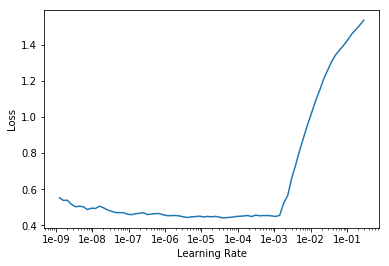

In [42]:
learn.unfreeze()
learn.lr_find(start_lr=1e-10)
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,precision,recall,f_beta,time
0,0.426471,0.421074,0.879946,0.876855,0.879946,0.877561,03:34
1,0.413250,0.439095,0.879852,0.880607,0.879852,0.874954,03:28
2,0.399963,0.413872,0.885151,0.883512,0.885151,0.883020,03:34
3,0.382629,0.391963,0.889478,0.888304,0.889478,0.886485,03:27
4,0.365978,0.378480,0.892488,0.890482,0.892488,0.890979,03:31
5,0.311751,0.395290,0.894432,0.893175,0.894432,0.892790,03:35
6,0.283703,0.372505,0.894118,0.894142,0.894118,0.893517,03:24
7,0.259770,0.372949,0.897724,0.896265,0.897724,0.896315,03:26
8,0.210423,0.410666,0.898790,0.898320,0.898790,0.896879,03:27
9,0.196633,0.400198,0.898351,0.896892,0.898351,0.897112,03:37


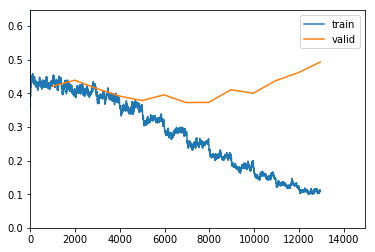

/opt/anaconda3/lib/python3.7/site-packages/fastai/callbacks/tracker.py:48: UserWarning: <class 'fastai.callbacks.tracker.SaveModelCallback'> conditioned on metric `error_rate` which is not available. Available metrics are: train_loss, valid_loss, accuracy, precision, recall, f_beta, time
  warn(f'{self.__class__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:]))}')


KeyboardInterrupt: 

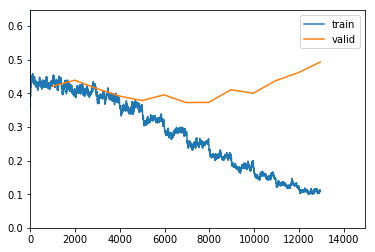

In [43]:
from fastai.callbacks import * 
learn.fit_one_cycle(15, slice(5e-4/(2.6**4),5e-4), moms=(0.8,0.7), 
                    callbacks=[ShowGraph(learn),SaveModelCallback(learn,monitor='error_rate',mode='min')])

In [44]:
learn.save('mobile_text_transformer_230319')

# Generate predictions

## load model

In [ ]:
data_lm = load_data(path, 'mobile_data_lm.pkl', bs=bs)
data_clas = load_data(path, 'mobile_data_clas.pkl', bs=bs)

learn = text_classifier_learner(data_clas, Transformer,wd=1e-1, drop_mult=0.6)
learn.load_encoder('mobile_fine_tuned_transformer_enc')
learn.load('mobile_text_transformer_230319')

## add test set for prediciton

In [2]:
import pandas as pd
from pathlib import Path

path = Path('/home/jupyter/shopee/data')
df = pd.read_csv(path/'mobile_train_v3_sss.csv')
df = df[df['is_valid'] == True].reset_index()

In [52]:
learn.validate()

[0.5113593, tensor(0.8978)]

In [48]:
test= TextList.from_df(df,cols='title')
data_clas.add_test(test)

## get predicitons

In [57]:
preds , y, losses = learn.get_preds(ds_type=DatasetType.Test, with_loss=True,ordered=True)
df = df.drop(columns=['image_path','Type','Actual','Predicted','Correct','is_valid'])
df_pred = pd.DataFrame(np.asarray(preds), columns=[str(i+31) + '_trf' for i in range(27)]).reset_index()

In [61]:
result = pd.concat([df, df_pred], axis=1)
result = result.drop(columns=['index'])

In [62]:
result.head()

,itemid,title,Category,31_trf,32_trf,33_trf,34_trf,35_trf,36_trf,37_trf,...,48_trf,49_trf,50_trf,51_trf,52_trf,53_trf,54_trf,55_trf,56_trf,57_trf
0,285735342,vivo v5,42,0.000078,0.000066,0.000031,0.000106,0.000107,0.000003,0.000021,...,0.000009,0.000007,0.000005,0.000005,0.000003,0.000005,0.000087,4.568442e-07,0.000012,3.722309e-05
1,1685256193,diskon icheckey premium ring stand holder hp b...,35,0.002655,0.000283,0.000056,0.001336,0.994831,0.000006,0.000064,...,0.000009,0.000029,0.000001,0.000002,0.000004,0.000043,0.000006,2.144178e-06,0.000038,4.818600e-07
2,1544415858,promo discon stock terbatas lg v30 plus dual s...,35,0.004041,0.000144,0.000247,0.000706,0.992935,0.000029,0.000225,...,0.000016,0.000038,0.000008,0.000012,0.000023,0.000063,0.000016,1.145261e-05,0.000090,3.164513e-06
3,1213429900,murah touchscreen sony experia z3 d6653 original,33,0.000225,0.000017,0.998232,0.000217,0.000541,0.000103,0.000165,...,0.000027,0.000023,0.000019,0.000003,0.000037,0.000037,0.000003,4.718957e-06,0.000006,1.077164e-05
4,1756878817,oppo a7 ram 4gb internal 64gb garansi resmi,41,0.000108,0.000142,0.000032,0.001453,0.000122,0.000018,0.000064,...,0.000019,0.000011,0.000009,0.000092,0.000006,0.000010,0.000008,3.042799e-06,0.000212,5.080068e-07


In [63]:
result.to_csv('mobile_ensemble_trf.csv', index=False)